In [1]:
from math import exp, factorial
import jax
jax.config.update("jax_enable_x64", True)
from jax import grad, jit, vmap
import jax.numpy as jnp
from jax.scipy.special import logsumexp
# This import is appropriate for factorial calculations in JAX.
from jax.scipy.special import gamma

# dual_annealing is a SciPy optimization function that does not directly support JAX arrays (jax.numpy).
from scipy.optimize import minimize, dual_annealing, differential_evolution
import matplotlib.pyplot as plt
import numpy as np
from tqdm.autonotebook import tqdm
from tqdm_joblib import tqdm_joblib
import functools
from joblib import Parallel, delayed
import os
import sys

# Get the notebook's directory
notebook_dir = os.getcwd()
# Add parent directory to path
project_root = os.path.dirname(notebook_dir)
sys.path.append(project_root)
# Import necessary libraries
import json
from concurrent.futures import ProcessPoolExecutor
import time
from jax import lax


/var/folders/8m/0wg1hssn6n79tjc8mh6p_spr0000gn/T/ipykernel_62670/4222515343.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
import numpy as np
import jax.numpy as jnp

## Experimental Parameters

In [3]:
# e_1
# Fiber lengths
Ls = jnp.linspace(0.1, 200, 1000)  # Fiber lengths in km
L_BC = Ls
e_1 = L_BC / 100

#e_2
P_dc_value = 6*10**-7  # Dark count probability
Y_0 = P_dc_value

# P_dc = 6 * 10 ** (-7)   # given in the paper, discussed with range from 10^-8 to 10^-5
# e_2 = -jnp.log(Y_0)

#e_3
e_mis = 5 * 10 ** -3  # Misalignment error probability
# 0.026 
e_d = e_mis
e_3 = e_d * 100
e_mis = 5*1e-3 # given in the paper, discussed with range from 0 to 0.1 

# e_4
# Detected events
n_X_values = [10 ** s for s in range(4, 10)]  # Detected events
# n_X_values = jnp.array([10**s for s in range(6, 11)], dtype=jnp.int64)
N = n_X_values
e_4 = N

# Prepare input combinations
# inputs = [(L, n_X) for L in np.linspace(0.1, 200, 100) for n_X in n_X_values]

## Other Parameters

In [4]:
alpha = 0.2  # Attenuation coefficient (dB/km), given in the paper
eta_Bob = 0.1  # Detector efficiency, given in the paper
P_ap = 0  # After-pulse probability, # 4*1e-2          # given in the paper, discussed with range from 0 to 0.1
f_EC = 1.16  # Error correction efficiency, given in the paper, range around 1.1
# secutity error 
epsilon_sec = 1e-10 # is equal to kappa * secrecy length Kl, range around 1e-10 Scalar, as it is a single value throughout the calculations.
# correlation error
epsilon_cor = 1e-15 # given in the paper, discussed with range from 0 to 10e-10
# Dark count probability
n_event = 1  # for single photon event
# Misalignment error probability 

## Optimal Parameters

In [5]:
# 0.6, 0.3, 0.13, 0.725, 0.6825
# 0.65, 0.15, 0.05, 0.61, 0.425
p_1 = mu_1 = 6e-1
p_2 = mu_2 = 2e-1
mu_3 = 2e-4
mu_k_values = jnp.array([mu_1, mu_2, mu_3])
p_3 = P_mu_1 = 0.05
p_4 = P_mu_2 = 0.6
P_mu_3 = 1 - P_mu_1 - P_mu_2
p_mu_k_values = jnp.array([P_mu_1, P_mu_2, P_mu_3])
p_5 = P_X_value = 5e-1
P_Z_value = 1 - P_X_value

In [6]:
from QKD_Functions.QKD_Functions import (
calculate_factorial,
calculate_tau_n,
    calculate_eta_ch,
    calculate_eta_sys,
    calculate_D_mu_k,
    calculate_n_X_total,
    calculate_N,
    calculate_n_Z_total,
    calculate_e_mu_k,
    calculate_e_obs,
    calculate_h,
    calculate_lambda_EC,
    calculate_sqrt_term,
    calculate_tau_n,
    calculate_n_pm, 
    calculate_S_0,
    calculate_S_1,
    calculate_m_mu_k,
    calculate_m_pm,
    calculate_v_1,
    calculate_gamma,
    calculate_Phi,
    calculate_LastTwoTerm,
    calculate_l,
    calculate_R,
    experimental_parameters,
    other_parameters,
    calculate_key_rates_and_metrics,
    penalty, 
    objective,
)

In [7]:
metric_info = {
    "eta_ch": ("Channel Transmittance $\eta_{ch}$", "Channel Transmittance vs Fiber Length"),
    "S_X_0": ("$S_{X_0}$", "Single-photon Events $S_{X_0}$ vs Fiber Length"),
    "S_Z_0": ("$S_{Z_0}$", "Single-photon Events $S_{Z_0}$ vs Fiber Length"),
    "tau_0": ("Tau 0", "Tau 0 vs Fiber Length"),
    "e_obs_X": ("$e_{obs,X}$", "Observed Error Rate $e_{obs,X}$ vs Fiber Length"),
    "S_X_1": ("$S_{X_1}$", "Single-photon Events $S_{X_1}$ vs Fiber Length"),
    "S_Z_1": ("$S_{Z_1}$", "Single-photon Events $S_{Z_1}$ vs Fiber Length"),
    "tau_1": ("Tau 1", "Tau 1 vs Fiber Length"),
    "v_Z_1": ("$v_{Z_1}$", "$v_{Z_1}$ vs Fiber Length"),
    "gamma": ("Gamma", "Gamma vs Fiber Length"),
    "Phi_X": ("$\Phi_{X}$", "$\Phi_{X}$ vs Fiber Length"),
    "binary_entropy_Phi": ("Binary Entropy of $\Phi$", "Binary Entropy of $\Phi$ vs Fiber Length"),
    "lambda_EC": ("Lambda EC", "Lambda EC vs Fiber Length"),
    "l_calculated": ("Calculated Secret Key Length $l$", "Calculated Secret Key Length $l$ vs Fiber Length"),
    "key_rates": ("Secret Key Rate per Pulse (bit)", "Secret Key Rate vs Fiber Length")
}

# Define range of `n_X` values and fiber lengths

Ls = jnp.linspace(0, 200, 1000)  # Fiber lengths from 0.1 km to 300 km, 100 points
params = (mu_1, mu_2, P_mu_1, P_mu_2, P_X_value)

# # Result storage dictionary for different `n_X` values
# Result storage dictionary for different `n_X` values
results = {n_X: {} for n_X in n_X_values}

# Main calculation loop for each `n_X` value
for n_X in n_X_values:
    results[n_X] = {metric: [] for metric in metric_info.keys()}
    results[n_X]["fiber_lengths"] = []  # Explicitly include fiber_lengths

    # Loop over each fiber length
    for L_values in Ls:
         
        result = objective(params, L_values, n_X, alpha, eta_Bob, P_dc_value, epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event)
        (
        penalized_key_rates,  # Updated key rates with penalty
        eta_ch_values,
        S_X_0_values,
        S_Z_0_values,
        S_X_1_values,
        S_Z_1_values,
        tau_0_values,
        tau_1_values,
        e_mu_k_values,
        e_obs_X_values,
        v_Z_1_values,
        gamma_results,
        Phi_X_values,
        binary_entropy_Phi_values,
        lambda_EC_values,
        l_calculated_values,
    ) = result

        # Append metrics to the results for the current n_X
        results[n_X]["fiber_lengths"].append(L_values)
        results[n_X]["key_rates"].append(penalized_key_rates)
        results[n_X]["eta_ch"].append(eta_ch_values)
        results[n_X]["S_X_0"].append(S_X_0_values)
        results[n_X]["S_Z_0"].append(S_Z_0_values)
        results[n_X]["S_X_1"].append(S_X_1_values)
        results[n_X]["S_Z_1"].append(S_Z_1_values)
        results[n_X]["tau_0"].append(tau_0_values)
        results[n_X]["tau_1"].append(tau_1_values)
        results[n_X]["e_obs_X"].append(e_obs_X_values)
        results[n_X]["v_Z_1"].append(v_Z_1_values)
        results[n_X]["gamma"].append(gamma_results)
        results[n_X]["Phi_X"].append(Phi_X_values)
        results[n_X]["binary_entropy_Phi"].append(binary_entropy_Phi_values)
        results[n_X]["lambda_EC"].append(lambda_EC_values)
        results[n_X]["l_calculated"].append(l_calculated_values)

TypeError: 'float' object cannot be interpreted as an integer

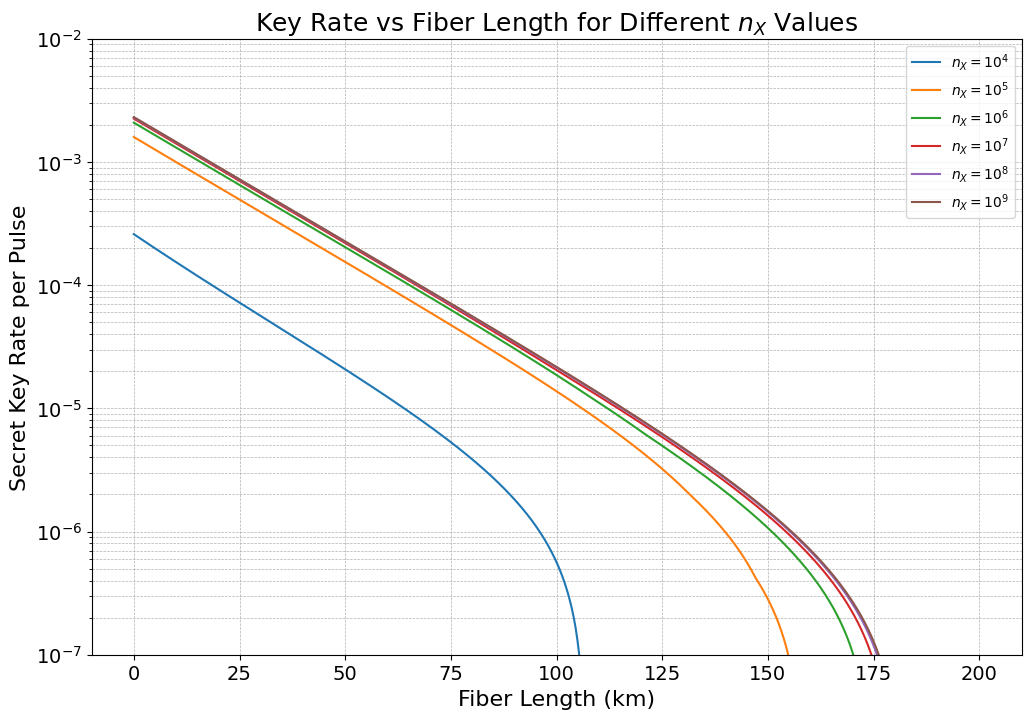

In [46]:
# import os
# import matplotlib.pyplot as plt

# # Ensure `output_dir` is defined
# output_dir = 'analytical_result'
# os.makedirs(output_dir, exist_ok=True)

# # Plot only key rates
# plt.figure(figsize=(12, 8))
# for n_X, data in results.items():
#     if "key_rates" in data and "fiber_lengths" in data:  # Check both keys exist
#         plt.plot(data["fiber_lengths"], data["key_rates"], label=f'$n_X = {n_X:.0e}$')

# # Plot settings
# plt.xlabel('Fiber Length (km)', fontsize=16)
# plt.ylabel('Key Rate', fontsize=16)
# plt.xticks(fontsize=14)  # Adjust tick label size for x-axis
# plt.yticks(fontsize=14)
# plt.yscale('log')
# plt.ylim(-(9), 0)  # Adjust the range if needed
# # plt.ylim(-7, 0)
# plt.title('Key Rate vs Fiber Length for Different $n_X$ Values', fontsize=18)
# plt.legend()
# plt.grid(True, which="both", linestyle='--', linewidth=0.5)

# # Save the plot
# filename = os.path.join(output_dir, 'key_rates_4_11.png')
# plt.savefig(filename)
# plt.show()

import os
import matplotlib.pyplot as plt
import numpy as np

# Enable LaTeX rendering for text (using MathText, not full LaTeX)
plt.rc('text', usetex=False)

# Ensure `output_dir` is defined
output_dir = 'analytical_result'
os.makedirs(output_dir, exist_ok=True)

# Plot only key rates
plt.figure(figsize=(12, 8))
for n_X, data in results.items():
    if "key_rates" in data and "fiber_lengths" in data:  # Check both keys exist
        exponent = int(np.log10(float(n_X)))  # Get the exponent for 10^k
        plt.plot(data["fiber_lengths"], data["key_rates"], label=r'$n_X = 10^{{{}}}$'.format(exponent))

# Plot settings
plt.title('Key Rate vs Fiber Length for Different $n_X$ Values', fontsize=18)
plt.legend()
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.xlabel('Fiber Length (km)', fontsize=16)
plt.ylabel('Secret Key Rate per Pulse', fontsize=16)
plt.xticks(fontsize=14)  # Adjust tick label size for x-axis
plt.yticks(fontsize=14)
plt.yscale('log')
plt.ylim(10**(-7), 10**(-2))  # Set y-axis range from 10^-7 to 10^-2
plt.yticks(np.arange(10**(-7), 10**(-2), [f"$10^{{{i}}}$" for i in range(10**(-7), 10**(-2))]))  # Set y-axis ticks from 10^-7 to 10^-1
# Save the plot
filename = os.path.join(output_dir, 'key_rates_4 SAVING_11.png')
plt.savefig(filename)
plt.show()


/var/folders/8m/0wg1hssn6n79tjc8mh6p_spr0000gn/T/ipykernel_62670/1181069458.py:25: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(-7, -1)  # Set y-axis range from 10^-7 to 10^-1


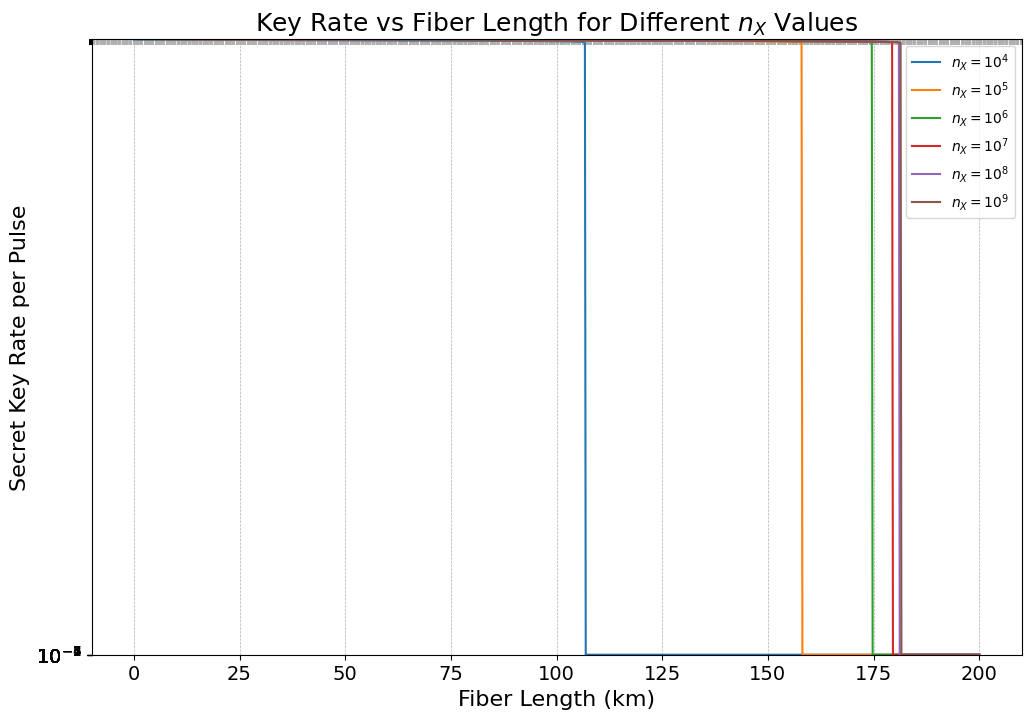

In [42]:
import os
import matplotlib.pyplot as plt
import numpy as np

# Enable LaTeX rendering for text (using MathText, not full LaTeX)
plt.rc('text', usetex=False)

# Ensure `output_dir` is defined
output_dir = 'analytical_result'
os.makedirs(output_dir, exist_ok=True)

# Plot only key rates
plt.figure(figsize=(12, 8))
for n_X, data in results.items():
    if "key_rates" in data and "fiber_lengths" in data:  # Check both keys exist
        exponent = int(np.log10(float(n_X)))  # Get the exponent for 10^k
        plt.plot(data["fiber_lengths"], data["key_rates"], label=r'$n_X = 10^{{{}}}$'.format(exponent))

# Plot settings
plt.xlabel('Fiber Length (km)', fontsize=16)
plt.ylabel('Secret Key Rate per Pulse', fontsize=16)
plt.xticks(fontsize=14)  # Adjust tick label size for x-axis
plt.yticks(fontsize=14)
plt.yscale('log')
plt.ylim(-7, -1)  # Set y-axis range from 10^-7 to 10^-1
plt.yticks(np.arange(-7, 0), [f"$10^{{{i}}}$" for i in range(-7, 0)])  # Set y-axis ticks from 10^-7 to 10^-1
plt.title('Key Rate vs Fiber Length for Different $n_X$ Values', fontsize=18)
plt.legend()
plt.grid(True, which="both", linestyle='--', linewidth=0.5)

# Save the plot
filename = os.path.join(output_dir, 'key_rates_4 SAVING_11.png')
plt.savefig(filename)
plt.show()

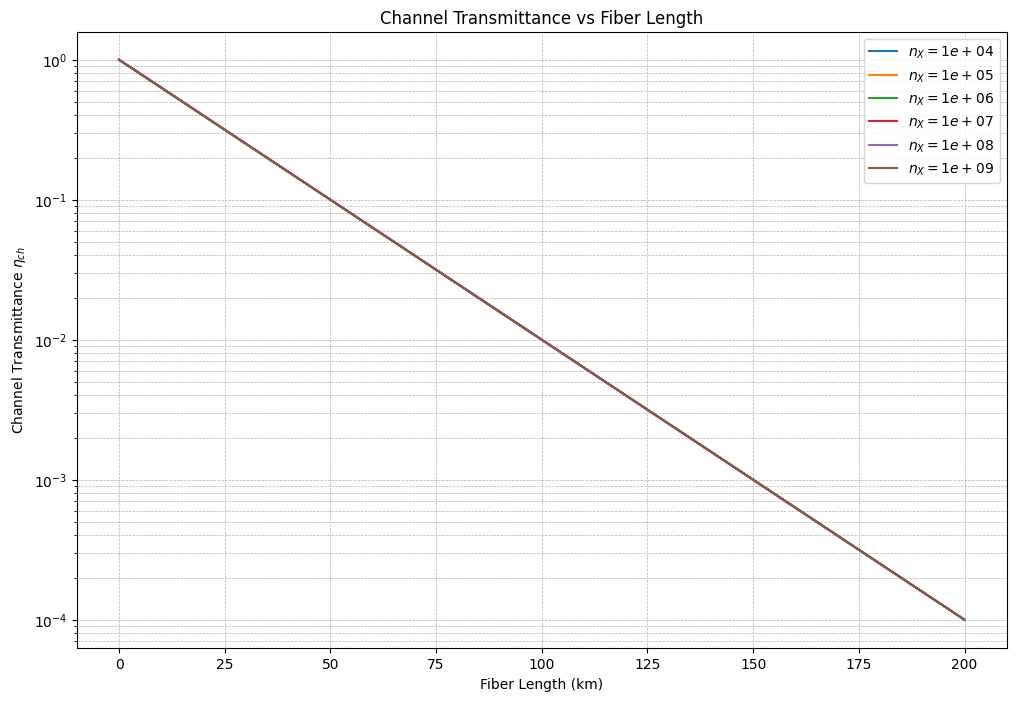

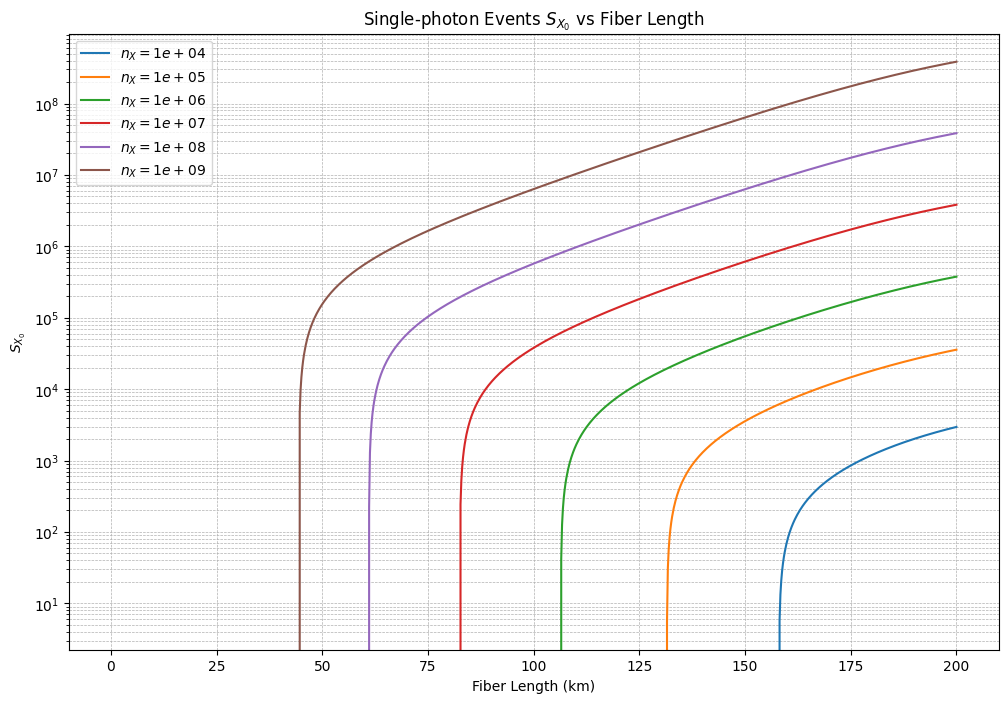

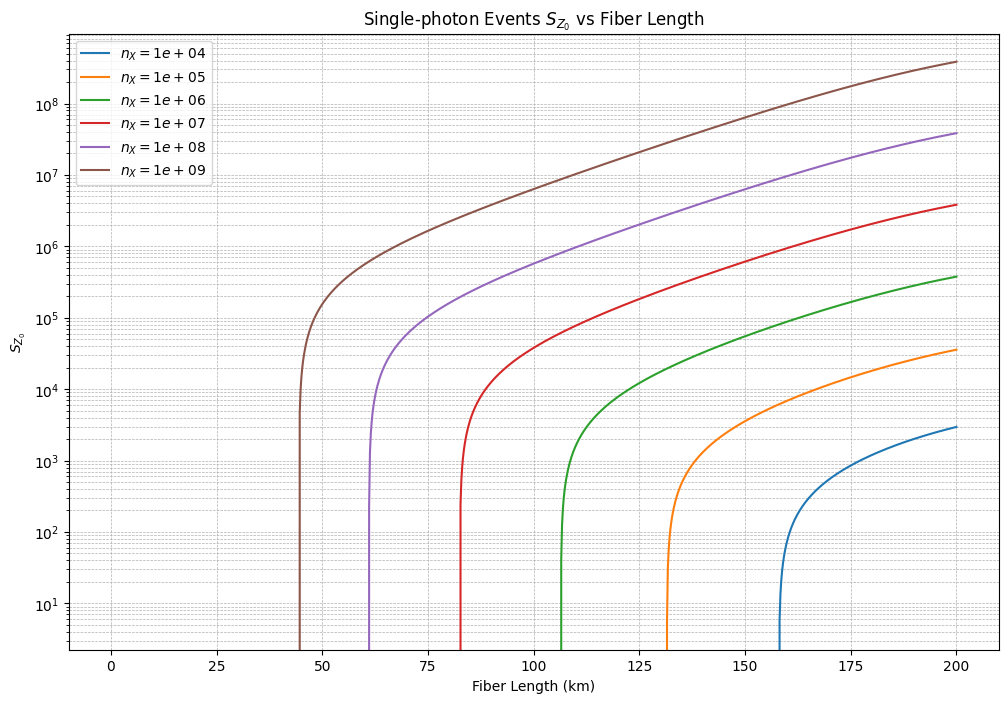

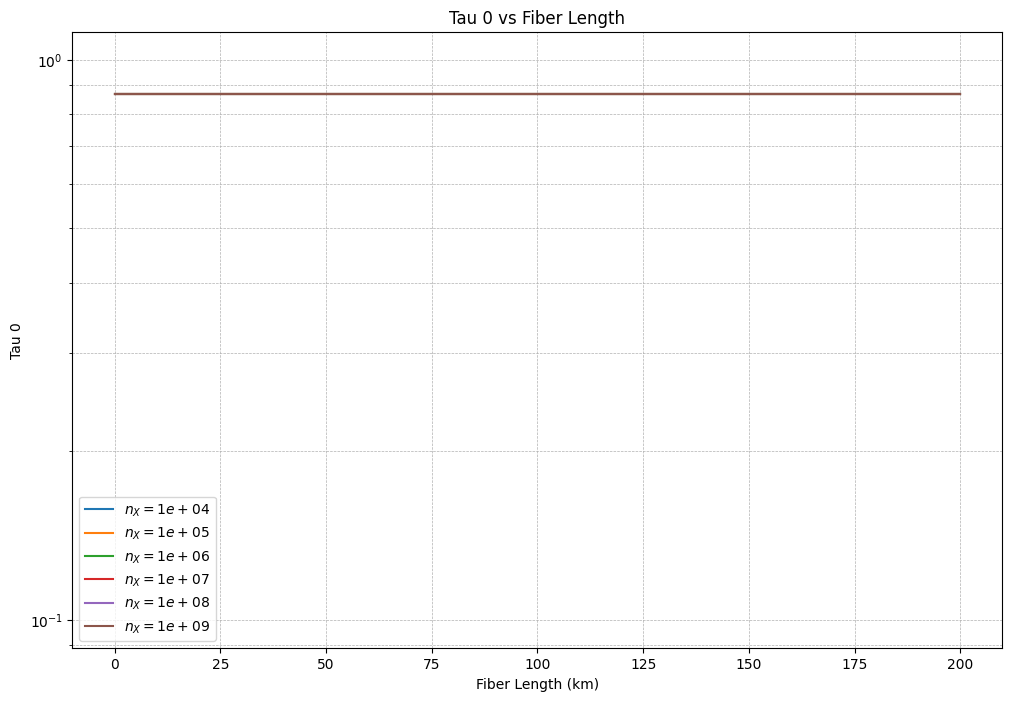

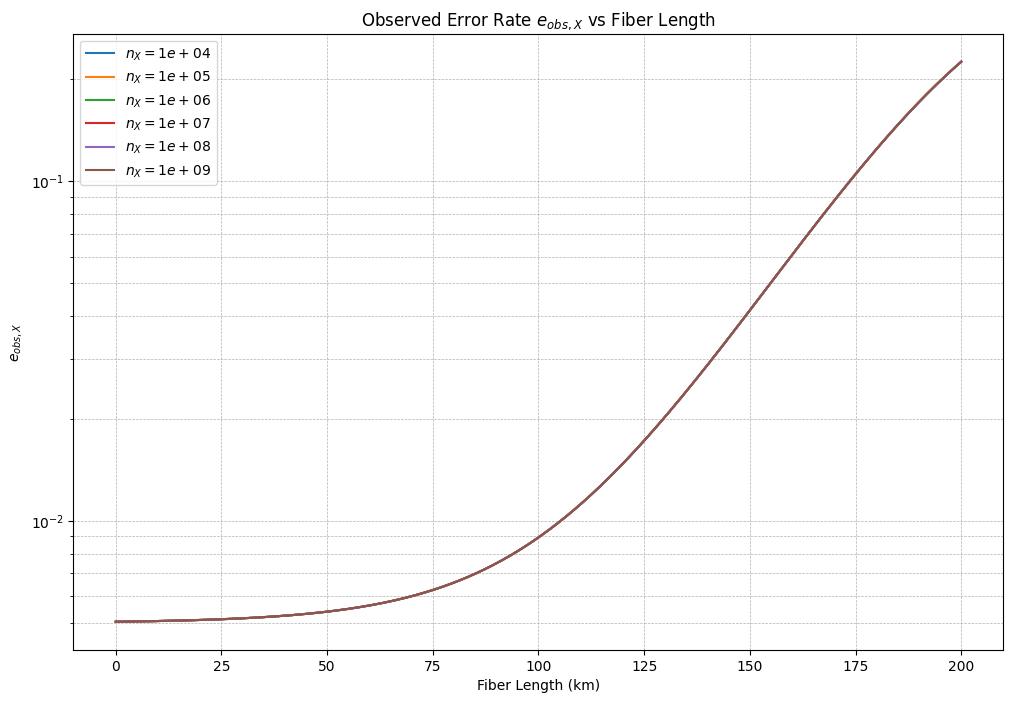

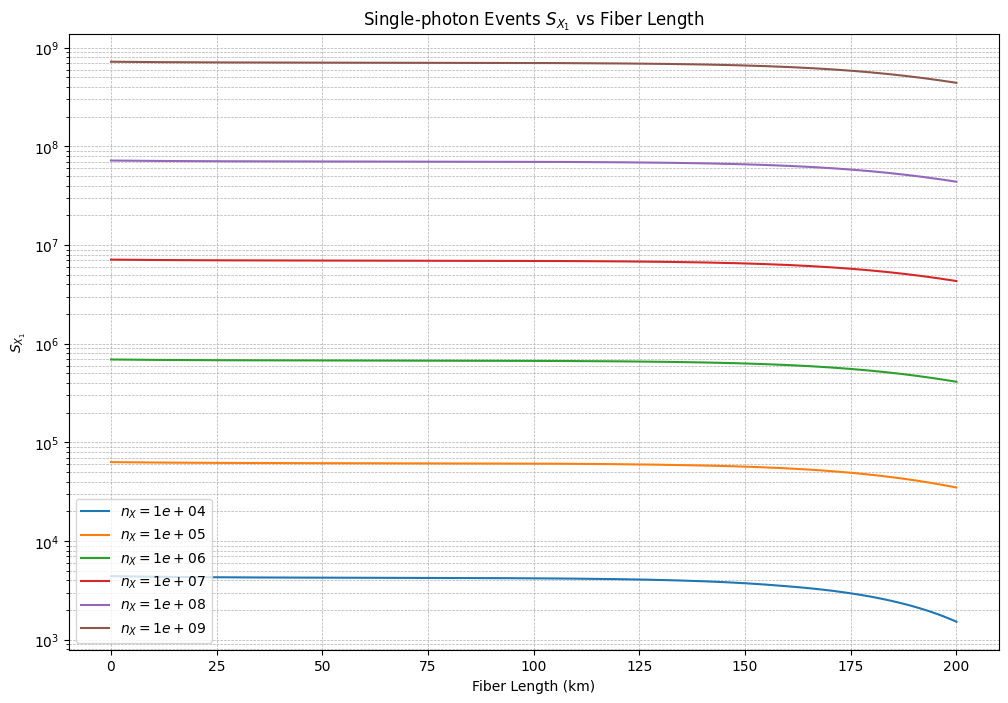

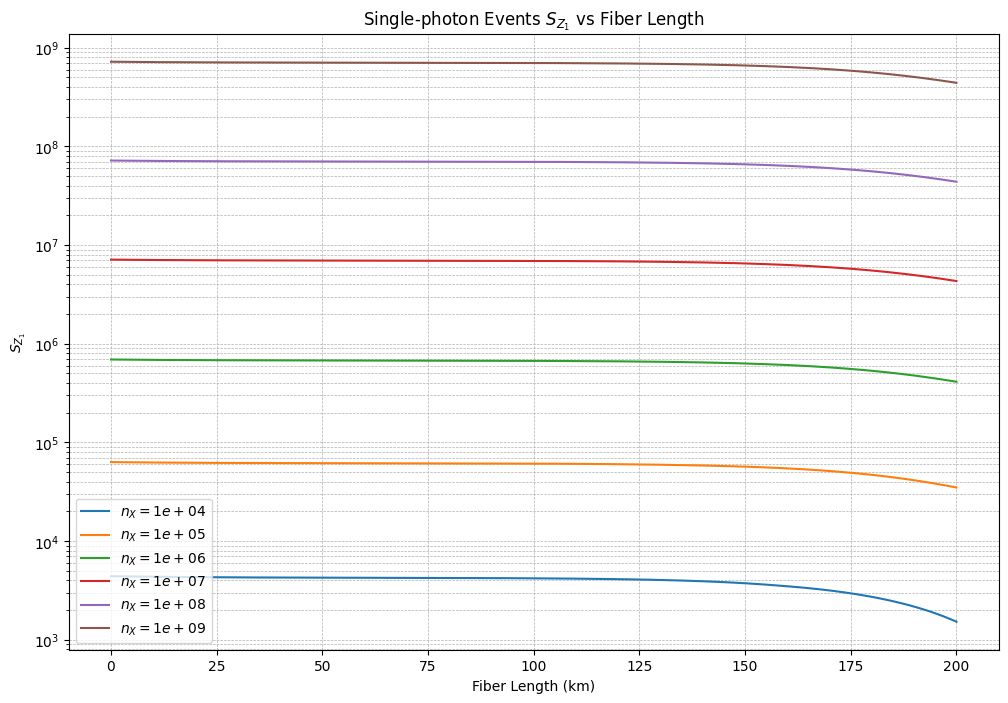

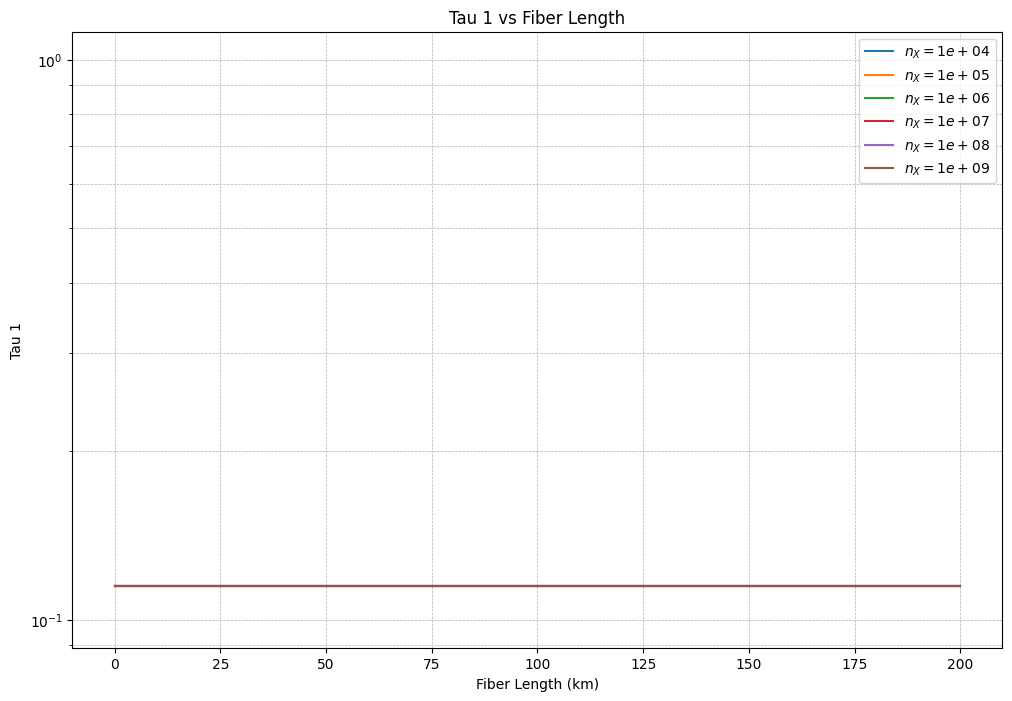

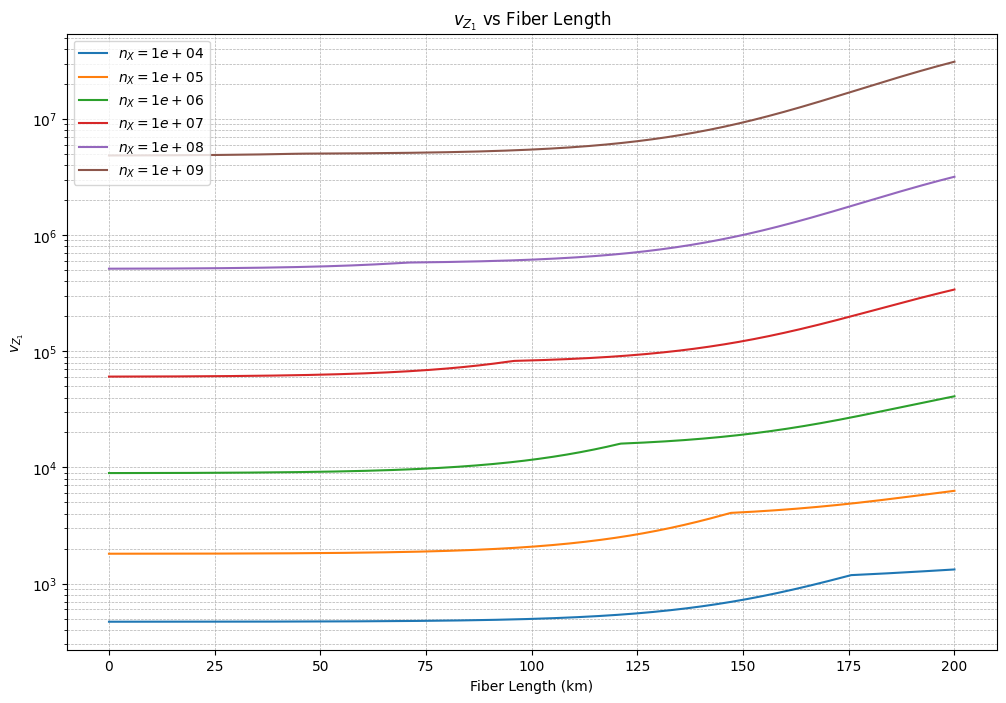

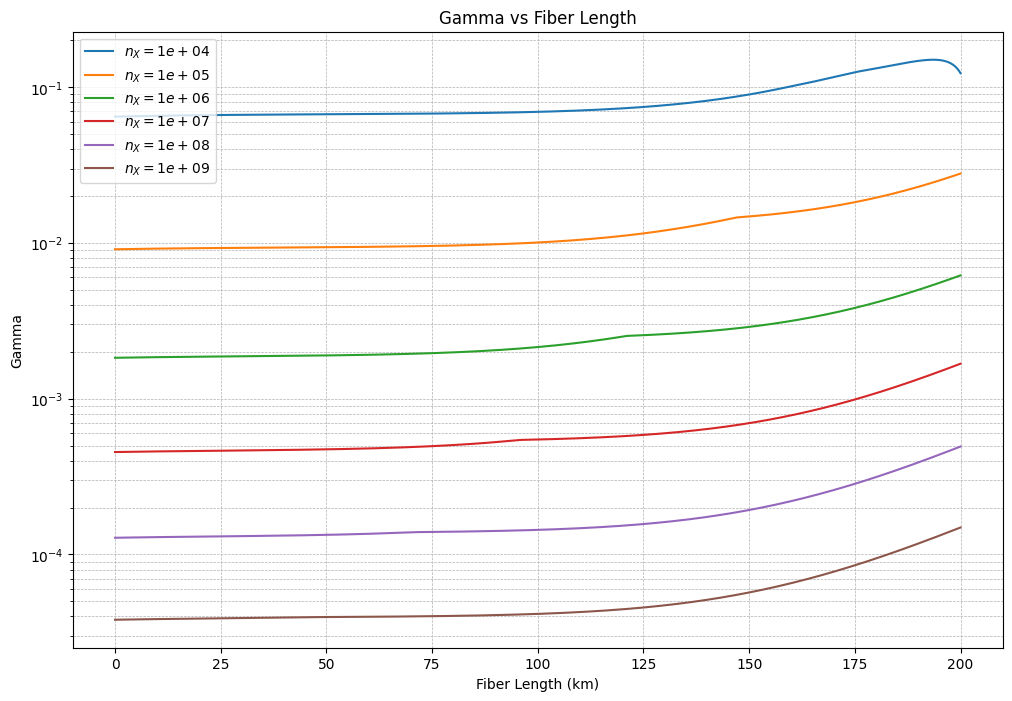

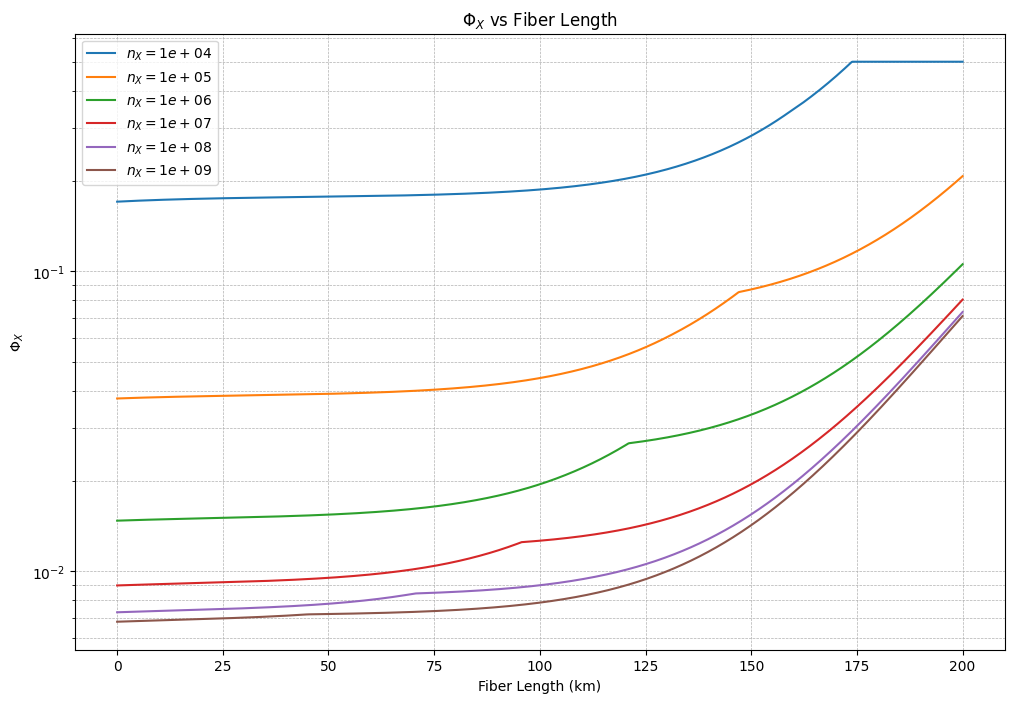

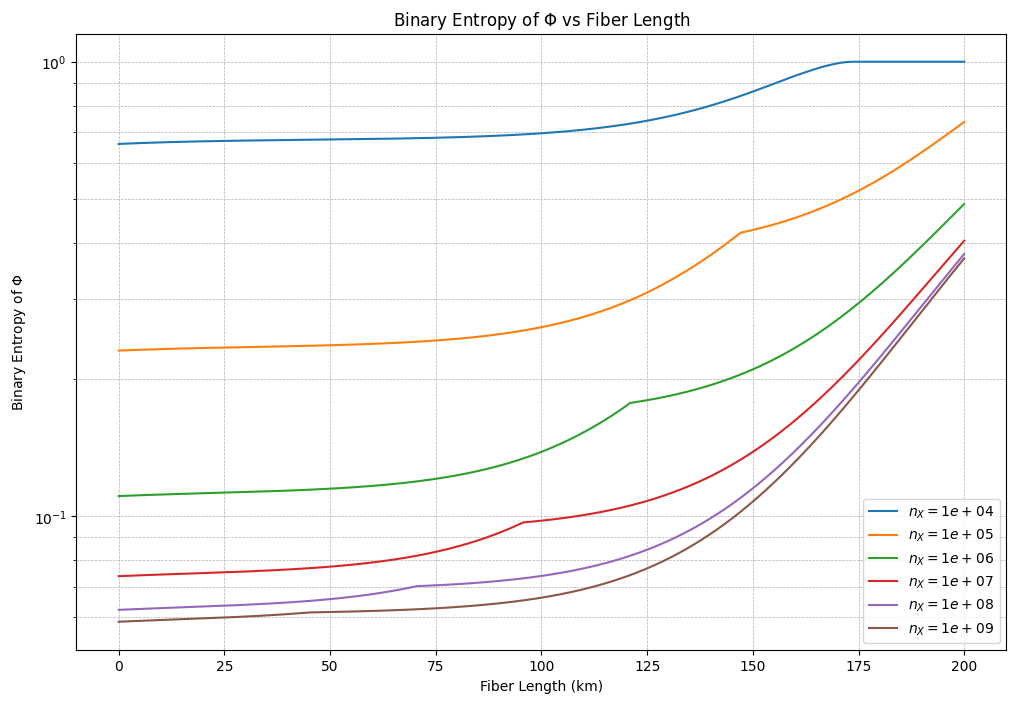

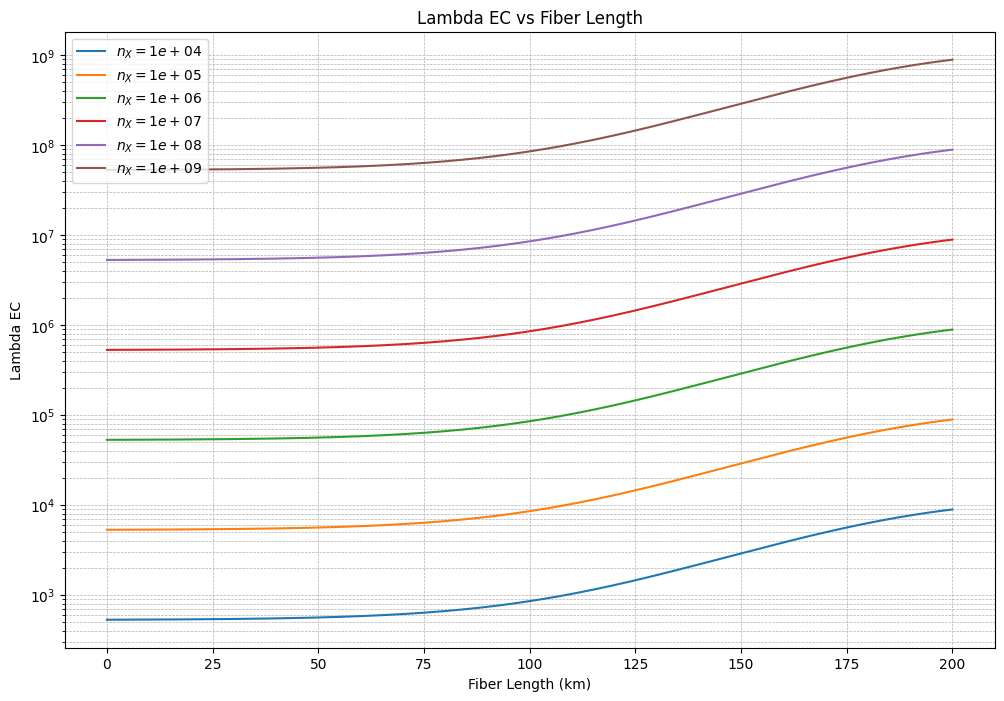

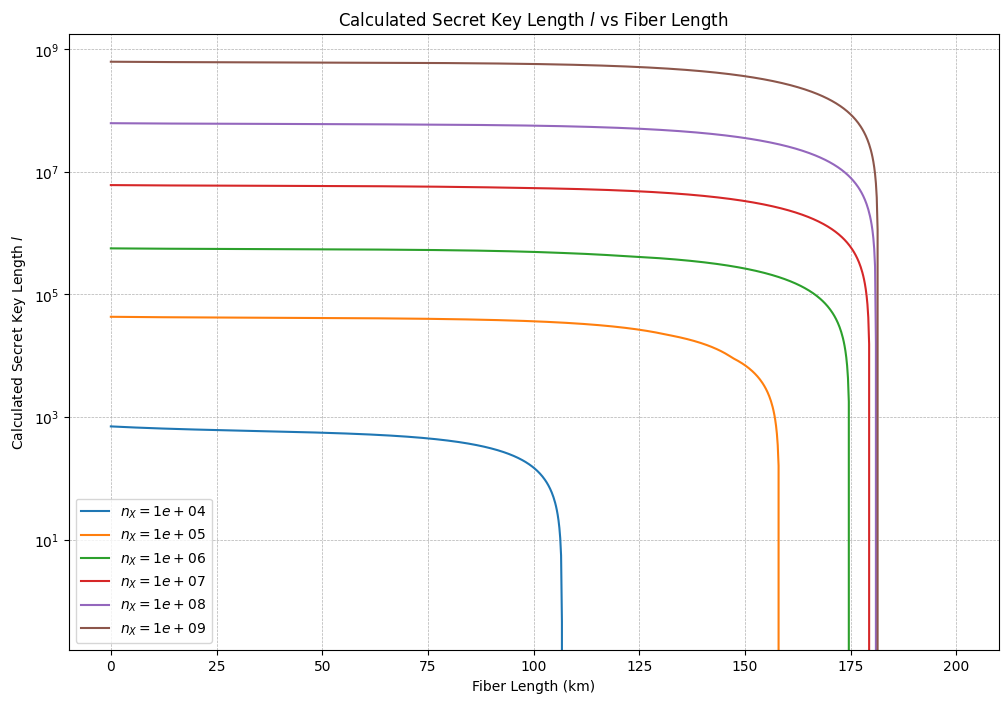

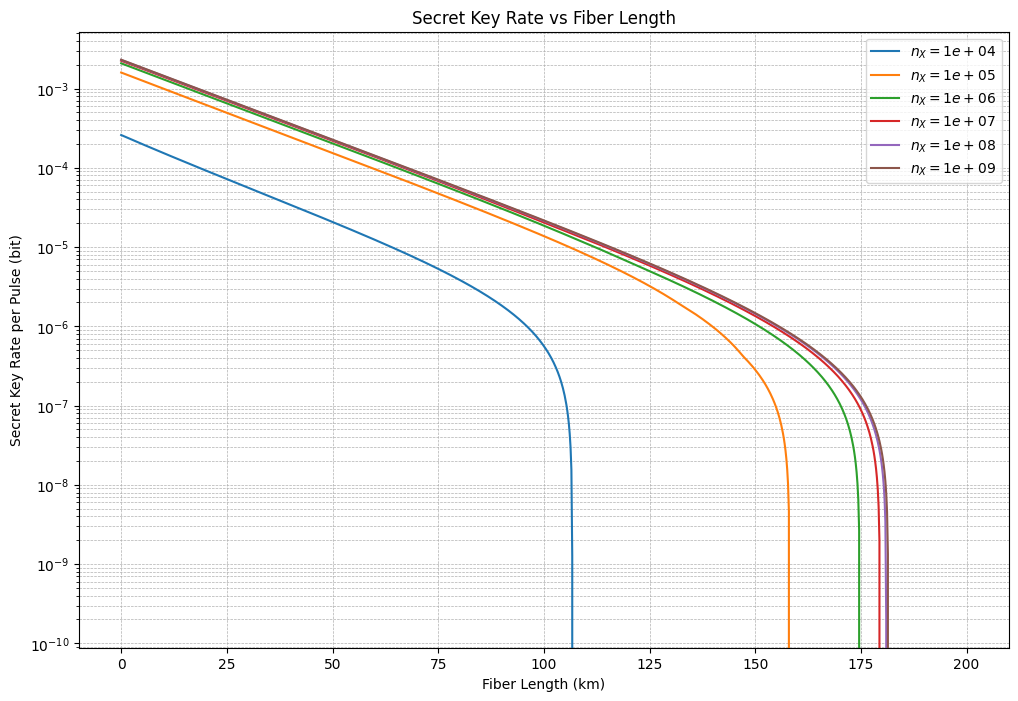

No key rates found for fiber lengths close to 0 km.


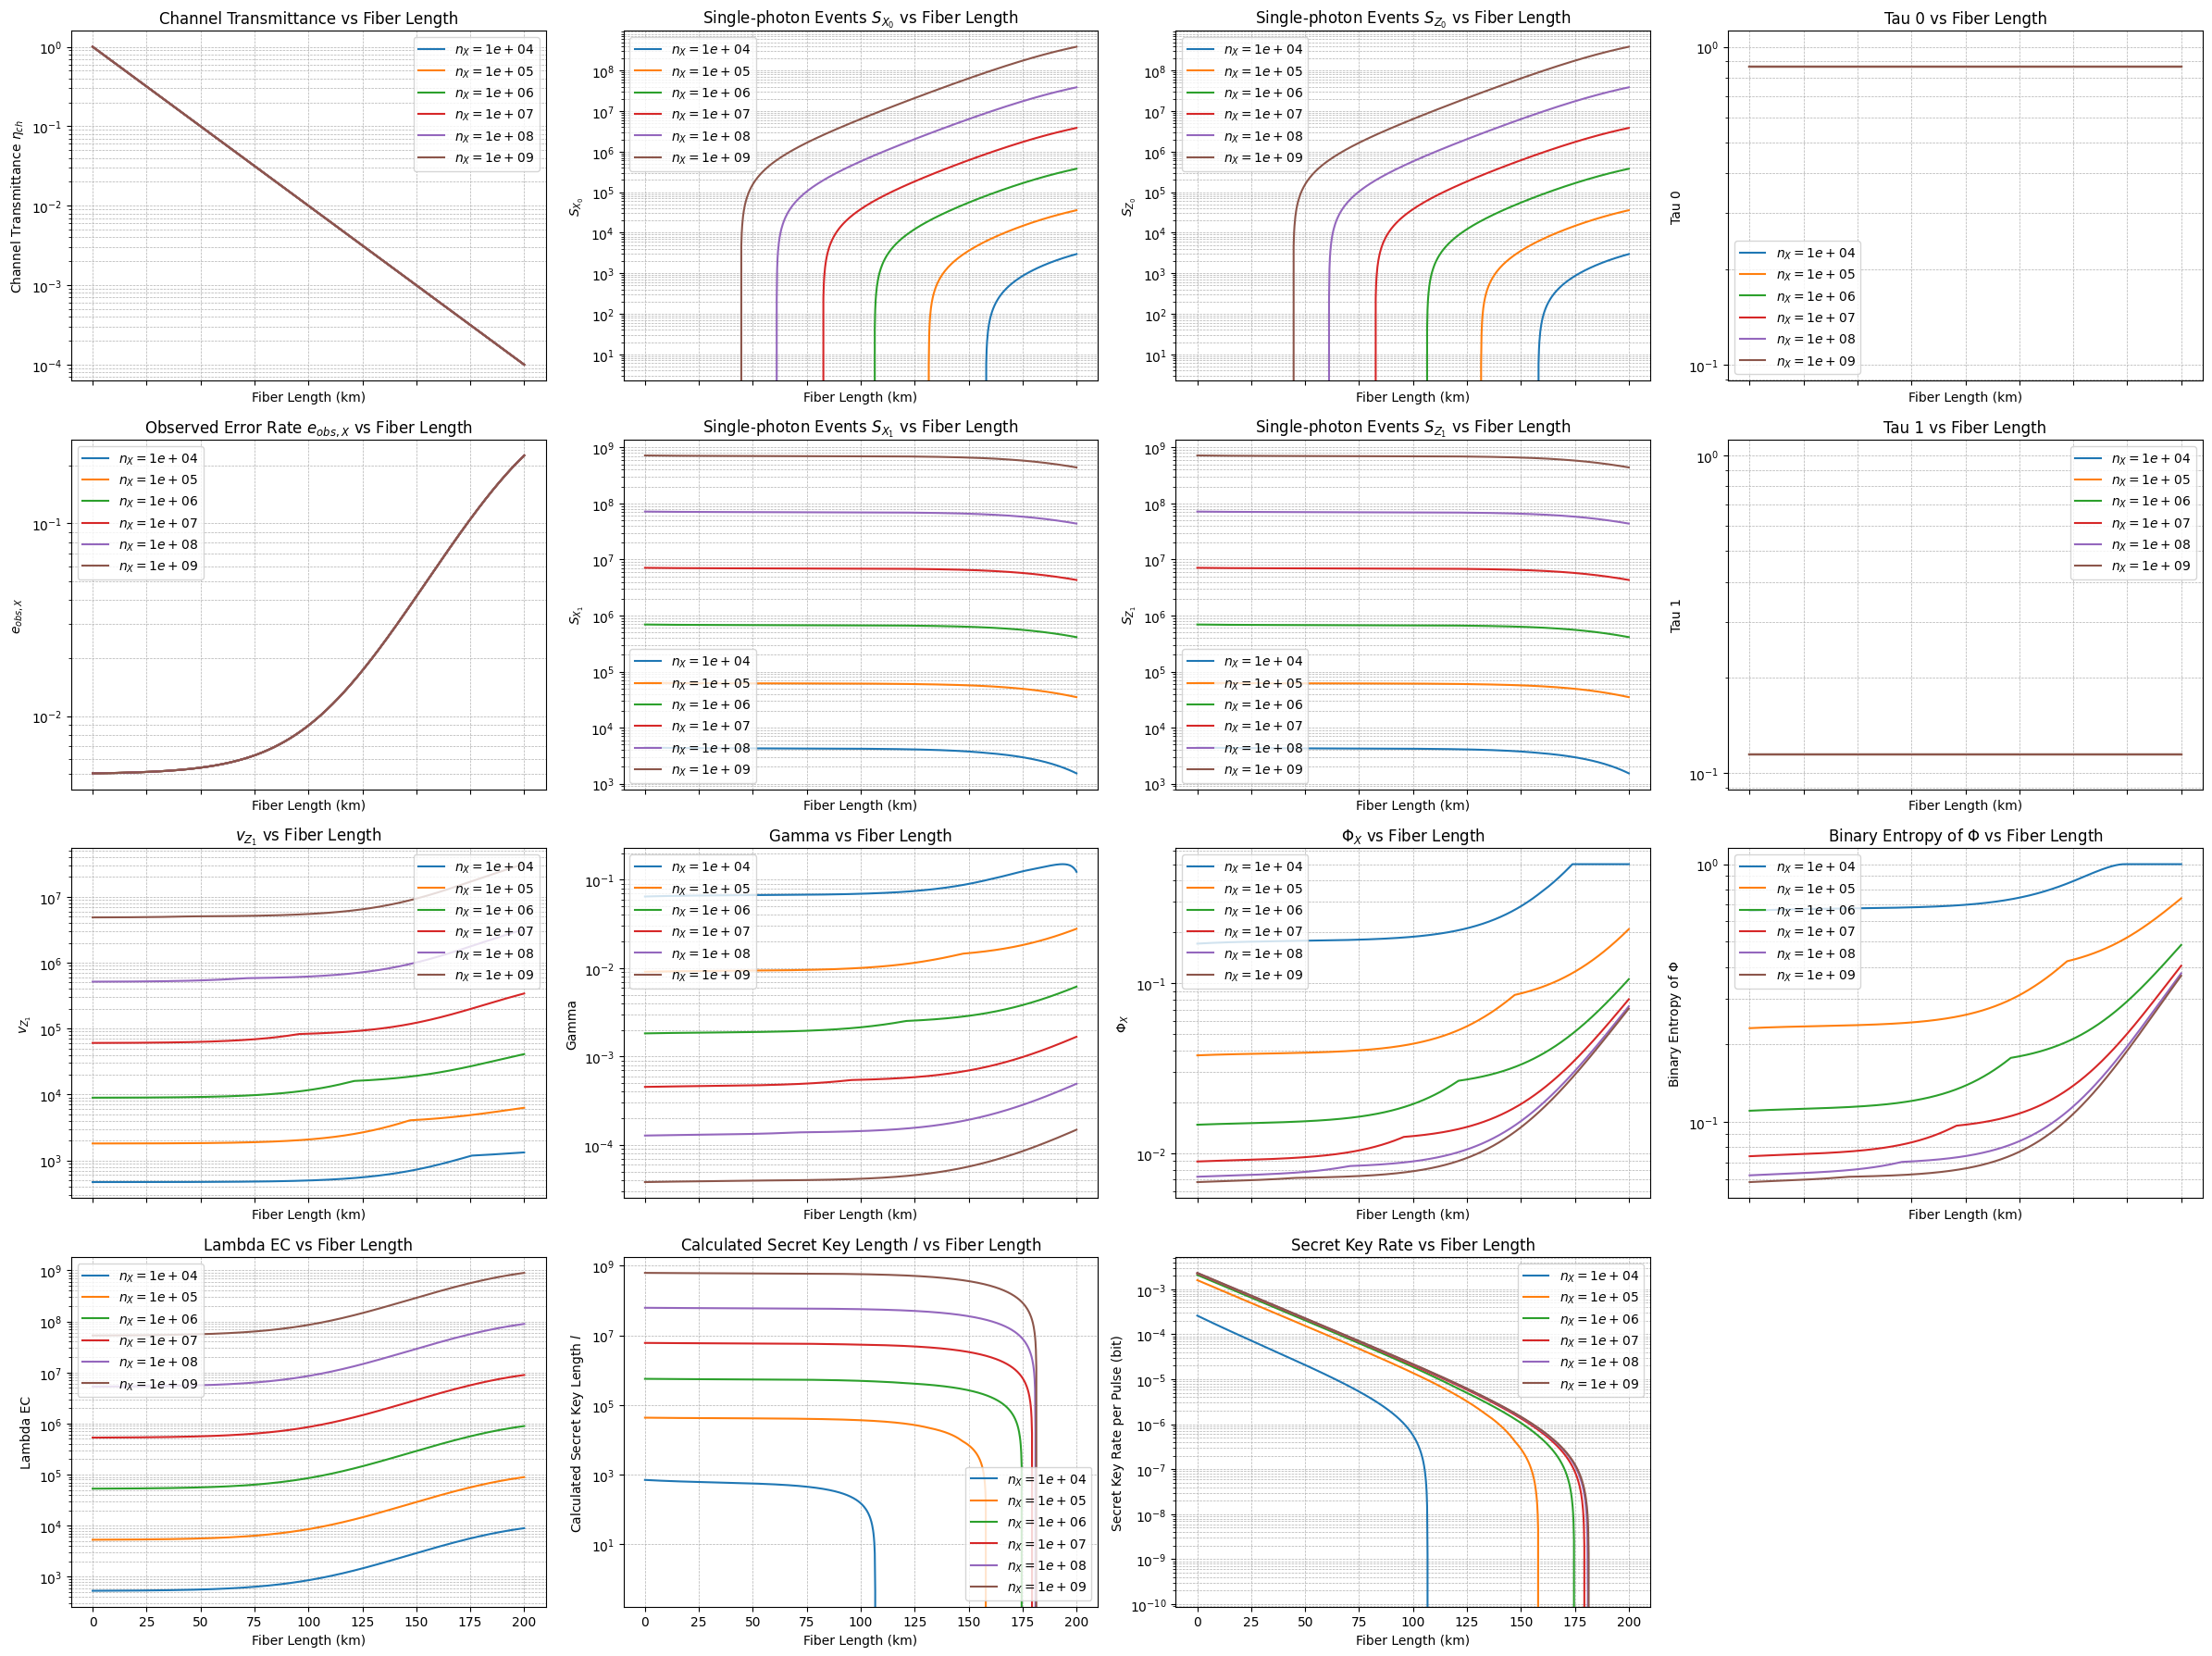

In [9]:
# Ensure `output_dir` is defined
import os
output_dir = 'analytical_result'
os.makedirs(output_dir, exist_ok=True)

# Plotting loop
for metric, (ylabel, title) in metric_info.items():
    plt.figure(figsize=(12, 8))
    for n_X, data in results.items():
        if metric in data and "fiber_lengths" in data:  # Check both keys exist
            plt.plot(data["fiber_lengths"], data[metric], label=f'$n_X = {n_X:.0e}$')
    plt.xlabel('Fiber Length (km)')
    plt.ylabel(ylabel)
    plt.yscale('log')
    plt.title(title)
    plt.legend()
    plt.grid(True, which="both", linestyle='--', linewidth=0.5)

    # Save the plot
    filename = os.path.join(output_dir, f'{metric}.png')
    plt.savefig(filename)
    plt.show()

# Define the number of rows and columns for the grid of subplots
num_metrics = len(metric_info)
rows = int(np.ceil(np.sqrt(num_metrics)))  # Rows of subplots
cols = int(np.ceil(num_metrics / rows))   # Columns of subplots

# Ensure the directory exists
output_dir = 'analytical_result'
os.makedirs(output_dir, exist_ok=True)

# Close all previous figures to avoid interference
plt.close('all')

fig, axes = plt.subplots(rows, cols, figsize=(24, 18), sharex=True)

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Plot each metric in its respective subplot
for idx, (metric, (ylabel, title)) in enumerate(metric_info.items()):
    ax = axes[idx]
    for n_X, data in results.items():
        if metric in data:
            ax.plot(data["fiber_lengths"], data[metric], label=f'$n_X = {n_X:.0e}$')
    ax.set_xlabel('Fiber Length (km)')
    ax.set_ylabel(ylabel)
    ax.set_yscale('log')  # Log scale for y-axis
    ax.set_title(title)
    ax.legend()
    ax.grid(True, which="both", linestyle='--', linewidth=0.5)

# Hide any unused subplots
for idx in range(len(metric_info), len(axes)):
    fig.delaxes(axes[idx])

# Assuming `results` contains the data and `fiber_lengths` corresponds to fiber lengths

key_rate_at_length_0 = {}

# Define a small tolerance for "near zero"
tolerance = 1e-6

key_rate_at_length_0 = {}

# Loop through the `results` dictionary to find the key rate at length near 0
for n_X, data in results.items():
    if "fiber_lengths" in data and "key_rate" in data:
        # Find indices where fiber lengths are near 0
        idx = np.where(np.abs(np.array(data["fiber_lengths"])) < tolerance)[0]
        if len(idx) > 0:  # Check if any such indices exist
            key_rate_at_length_0[n_X] = data["key_rate"][idx[0]]

# Display the results
if key_rate_at_length_0:
    print("Key rates at fiber length close to 0 km:")
    for n_X, key_rate in key_rate_at_length_0.items():
        print(f"n_X = {n_X:.0e}, Fiber Length ≈ 0 km, Key Rate = {key_rate:.2e}")
else:
    print("No key rates found for fiber lengths close to 0 km.")
    
# Adjust layout to prevent overlap
plt.tight_layout()

# Save the grid of plots before showing it
filename = os.path.join(output_dir, 'all_metrics_grid.png')
plt.savefig(filename)

# Display the plot
plt.show()

In [10]:
# Initialize dictionary to store key rates at L = 0
key_rate_at_L0 = {}

# Define a small tolerance to check for fiber length near zero
tolerance = 1e-6

# Loop through each n_X value in the results dictionary
for n_X, data in results.items():
    if "fiber_lengths" in data and "key_rates" in data:  # Ensure required keys exist
        # Find indices where fiber length is near zero
        idx = np.where(np.abs(np.array(data["fiber_lengths"])) < tolerance)[0]
        if len(idx) > 0:  # If such indices exist
            key_rate_at_L0[n_X] = data["key_rates"][idx[0]]  # Extract the key rate

# Display the results
if key_rate_at_L0:
    print("Key rates at fiber length L = 0 km (analytical):")
    for n_X, key_rate in key_rate_at_L0.items():
        print(f"n_X = {n_X:.0e}, Key Rate = {key_rate:.2e}")
else:
    print("No key rates found for fiber length L = 0 km.")

Key rates at fiber length L = 0 km (analytical):
n_X = 1e+04, Key Rate = 2.59e-04
n_X = 1e+05, Key Rate = 1.59e-03
n_X = 1e+06, Key Rate = 2.08e-03
n_X = 1e+07, Key Rate = 2.24e-03
n_X = 1e+08, Key Rate = 2.30e-03
n_X = 1e+09, Key Rate = 2.31e-03


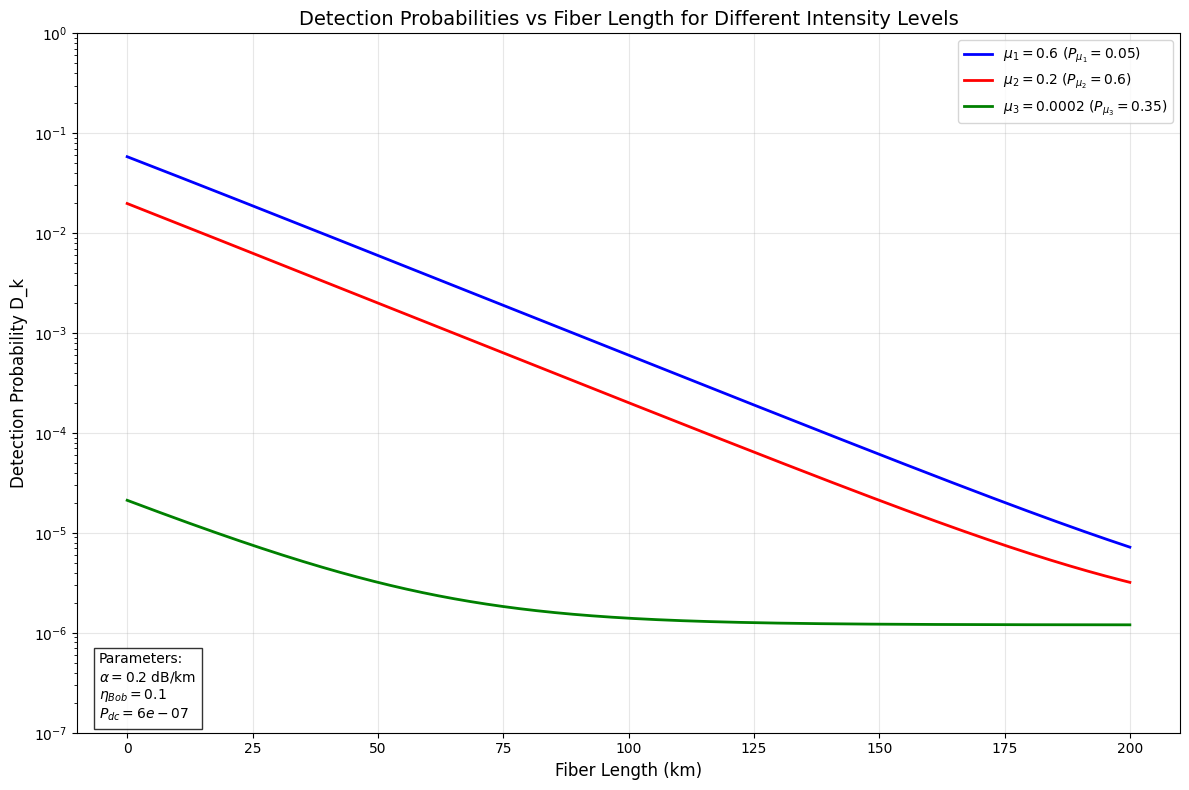

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
L = np.linspace(0, 200, 1000)  # Distance from 0 to 200 km
alpha = 0.2  # Attenuation coefficient (dB/km)
eta_Bob = 0.1  # Detector efficiency
P_dc = 6e-7  # Dark count probability

# Intensity levels and their probabilities
mu_values = [0.6, 0.2, 2e-4]  # μ₁, μ₂, μ₃
P_mu_values = [0.05, 0.6, 0.35]  # Corresponding probabilities

# Calculate transmittances
eta_ch = 10**(-alpha * L / 10)
eta_sys = eta_Bob * eta_ch

# Create the plot
plt.figure(figsize=(12, 8))

# Plot D_k for each intensity level
colors = ['blue', 'red', 'green']
labels = [f'$\\mu_1 = {mu_values[0]}$ ($P_{{\\mu_1}} = {P_mu_values[0]}$)',
         f'$\\mu_2 = {mu_values[1]}$ ($P_{{\\mu_2}} = {P_mu_values[1]}$)',
         f'$\\mu_3 = {mu_values[2]}$ ($P_{{\\mu_3}} = {P_mu_values[2]}$)']

for mu_k, color, label in zip(mu_values, colors, labels):
    D_k = 1 - (1 - 2 * P_dc) * np.exp(-eta_sys * mu_k)
    plt.plot(L, D_k, color=color, label=label, linewidth=2)

plt.xlabel('Fiber Length (km)', fontsize=12)
plt.ylabel('Detection Probability D_k', fontsize=12)
plt.title('Detection Probabilities vs Fiber Length for Different Intensity Levels', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.yscale('log')  # Using log scale for better visualization
plt.ylim(1e-7, 1)

# Add parameters text box with LaTeX formatting
params_text = f'Parameters:\n$\\alpha = {alpha}$ dB/km\n$\\eta_{{Bob}} = {eta_Bob}$\n$P_{{dc}} = {P_dc}$'
plt.text(0.02, 0.02, params_text, transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.8), fontsize=10)

plt.tight_layout()
plt.savefig('Detection_Probabilities_vs_Fiber_Length_for_Different_Intensity_Levels.png')
plt.show()

In [12]:
# %% [markdown]
# ### Verify Percentage Gains in Secret Key Rate at 100 km and 150 km

# Define the fiber lengths to check
target_lengths = [100.0, 150.0]

# Initialize dictionaries to store key rates at the target lengths
key_rates_at_lengths = {length: {} for length in target_lengths}

# Tolerance for matching fiber lengths (since Ls is a linspace, exact matches may not exist)
tolerance = 0.2  # Allow for small numerical differences

# Extract key rates at the target lengths for each n_X
for length in target_lengths:
    for n_X, data in results.items():
        if "fiber_lengths" in data and "key_rates" in data:
            # Find the index of the closest fiber length to the target
            idx = np.argmin(np.abs(np.array(data["fiber_lengths"]) - length))
            if np.abs(data["fiber_lengths"][idx] - length) < tolerance:
                key_rates_at_lengths[length][n_X] = data["key_rates"][idx]

# Calculate and print percentage gains for consecutive n_X values
for length in target_lengths:
    print(f"\nKey rates and percentage gains at fiber length {length} km:")
    n_X_sorted = sorted(key_rates_at_lengths[length].keys())
    
    # Print key rates
    for n_X in n_X_sorted:
        key_rate = key_rates_at_lengths[length][n_X]
        print(f"n_X = {n_X:.0e}, Key Rate = {key_rate:.2e} (log10(Key Rate) = {np.log10(key_rate):.2f})")
    
    # Calculate percentage gains between consecutive n_X values
    print(f"Percentage gains at fiber length {length} km:")
    for i in range(len(n_X_sorted) - 1):
        n_X_1, n_X_2 = n_X_sorted[i], n_X_sorted[i + 1]
        R_1, R_2 = key_rates_at_lengths[length][n_X_1], key_rates_at_lengths[length][n_X_2]
        if R_1 > 0:  # Avoid division by zero
            percentage_gain = ((R_2 - R_1) / R_1) * 100
            print(f"From n_X = {n_X_1:.0e} to {n_X_2:.0e}: {percentage_gain:.1f}%")
        else:
            print(f"From n_X = {n_X_1:.0e} to {n_X_2:.0e}: Not calculable (R_1 <= 0)")


Key rates and percentage gains at fiber length 100.0 km:
n_X = 1e+04, Key Rate = 5.53e-07 (log10(Key Rate) = -6.26)
n_X = 1e+05, Key Rate = 1.37e-05 (log10(Key Rate) = -4.86)
n_X = 1e+06, Key Rate = 1.85e-05 (log10(Key Rate) = -4.73)
n_X = 1e+07, Key Rate = 2.04e-05 (log10(Key Rate) = -4.69)
n_X = 1e+08, Key Rate = 2.13e-05 (log10(Key Rate) = -4.67)
n_X = 1e+09, Key Rate = 2.16e-05 (log10(Key Rate) = -4.67)
Percentage gains at fiber length 100.0 km:
From n_X = 1e+04 to 1e+05: 2372.3%
From n_X = 1e+05 to 1e+06: 35.5%
From n_X = 1e+06 to 1e+07: 10.0%
From n_X = 1e+07 to 1e+08: 4.5%
From n_X = 1e+08 to 1e+09: 1.4%

Key rates and percentage gains at fiber length 150.0 km:
n_X = 1e+04, Key Rate = -1.07e-06 (log10(Key Rate) = nan)
n_X = 1e+05, Key Rate = 2.85e-07 (log10(Key Rate) = -6.55)
n_X = 1e+06, Key Rate = 1.07e-06 (log10(Key Rate) = -5.97)
n_X = 1e+07, Key Rate = 1.35e-06 (log10(Key Rate) = -5.87)
n_X = 1e+08, Key Rate = 1.44e-06 (log10(Key Rate) = -5.84)
n_X = 1e+09, Key Rate = 1.47

/var/folders/8m/0wg1hssn6n79tjc8mh6p_spr0000gn/T/ipykernel_62670/3203910743.py:30: RuntimeWarning: invalid value encountered in log10
  print(f"n_X = {n_X:.0e}, Key Rate = {key_rate:.2e} (log10(Key Rate) = {np.log10(key_rate):.2f})")


In [13]:
# Experimental Parameters
Ls = jnp.linspace(0, 200, 1000)  # Fiber lengths from 0 to 200 km, 1000 points
P_dc_value = 6e-7  # Dark count probability
e_mis = 5e-3  # Misalignment error probability
n_X_values = [10 ** s for s in range(4, 10)]  # Detected events: 10^4 to 10^9

# Other Parameters
alpha = 0.2  # Attenuation coefficient (dB/km)
eta_Bob = 0.1  # Detector efficiency
P_ap = 0  # After-pulse probability
f_EC = 1.16  # Error correction efficiency
epsilon_sec = 1e-10  # Security error
epsilon_cor = 1e-15  # Correlation error
n_event = 1  # For single photon event

# Optimal Parameters
mu_1 = 6e-1
mu_2 = 2e-1
mu_3 = 2e-4
P_mu_1 = 0.05
P_mu_2 = 0.6
P_mu_3 = 1 - P_mu_1 - P_mu_2
P_X_value = 5e-1
params = (mu_1, mu_2, P_mu_1, P_mu_2, P_X_value)

metric_info = {
    "eta_ch": ("Channel Transmittance $\eta_{ch}$", "Channel Transmittance vs Fiber Length"),
    "S_X_0": ("$S_{X_0}$", "Single-photon Events $S_{X_0}$ vs Fiber Length"),
    "S_Z_0": ("$S_{Z_0}$", "Single-photon Events $S_{Z_0}$ vs Fiber Length"),
    "tau_0": ("Tau 0", "Tau 0 vs Fiber Length"),
    "e_obs_X": ("$e_{obs,X}$", "Observed Error Rate $e_{obs,X}$ vs Fiber Length"),
    "S_X_1": ("$S_{X_1}$", "Single-photon Events $S_{X_1}$ vs Fiber Length"),
    "S_Z_1": ("$S_{Z_1}$", "Single-photon Events $S_{Z_1}$ vs Fiber Length"),
    "tau_1": ("Tau 1", "Tau 1 vs Fiber Length"),
    "v_Z_1": ("$v_{Z_1}$", "$v_{Z_1}$ vs Fiber Length"),
    "gamma": ("Gamma", "Gamma vs Fiber Length"),
    "Phi_X": ("$\Phi_{X}$", "$\Phi_{X}$ vs Fiber Length"),
    "binary_entropy_Phi": ("Binary Entropy of $\Phi$", "Binary Entropy of $\Phi$ vs Fiber Length"),
    "lambda_EC": ("Lambda EC", "Lambda EC vs Fiber Length"),
    "l_calculated": ("Calculated Secret Key Length $l$", "Calculated Secret Key Length $l$ vs Fiber Length"),
    "key_rates": ("Secret Key Rate per Pulse (bit)", "Secret Key Rate vs Fiber Length")
}

# %% [markdown]
# ### Compute Results

# Initialize the results dictionary
results = {n_X: {} for n_X in n_X_values}

# Main calculation loop for each n_X value
for n_X in n_X_values:
    results[n_X] = {metric: [] for metric in metric_info.keys()}
    results[n_X]["fiber_lengths"] = []  # Explicitly include fiber_lengths

    # Loop over each fiber length
    for L_values in Ls:
        result = objective(params, L_values, n_X, alpha, eta_Bob, P_dc_value, 
                          epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event)
        (
            penalized_key_rates, eta_ch_values, S_X_0_values, S_Z_0_values,
            S_X_1_values, S_Z_1_values, tau_0_values, tau_1_values,
            e_mu_k_values, e_obs_X_values, v_Z_1_values, gamma_results,
            Phi_X_values, binary_entropy_Phi_values, lambda_EC_values,
            l_calculated_values
        ) = result

        # Append metrics to the results for the current n_X
        results[n_X]["fiber_lengths"].append(L_values)
        results[n_X]["key_rates"].append(penalized_key_rates)
        results[n_X]["eta_ch"].append(eta_ch_values)
        results[n_X]["S_X_0"].append(S_X_0_values)
        results[n_X]["S_Z_0"].append(S_Z_0_values)
        results[n_X]["S_X_1"].append(S_X_1_values)
        results[n_X]["S_Z_1"].append(S_Z_1_values)
        results[n_X]["tau_0"].append(tau_0_values)
        results[n_X]["tau_1"].append(tau_1_values)
        results[n_X]["e_obs_X"].append(e_obs_X_values)
        results[n_X]["v_Z_1"].append(v_Z_1_values)
        results[n_X]["gamma"].append(gamma_results)
        results[n_X]["Phi_X"].append(Phi_X_values)
        results[n_X]["binary_entropy_Phi"].append(binary_entropy_Phi_values)
        results[n_X]["lambda_EC"].append(lambda_EC_values)
        results[n_X]["l_calculated"].append(l_calculated_values)

# %% [markdown]
# ### Verify Percentage Gains in Secret Key Rate at 100 km and 150 km

# Define the fiber lengths to check
target_lengths = [100.0, 150.0]

# Initialize dictionaries to store key rates at the target lengths
key_rates_at_lengths = {length: {} for length in target_lengths}

# Tolerance for matching fiber lengths (since Ls is a linspace, exact matches may not exist)
tolerance = 0.2  # Allow for small numerical differences

# Debugging: Print the first few fiber lengths to confirm the range
for n_X in n_X_values:
    print(f"n_X = {n_X:.0e}, First few fiber lengths: {results[n_X]['fiber_lengths'][:5]}")
    print(f"n_X = {n_X:.0e}, Last few fiber lengths: {results[n_X]['fiber_lengths'][-5:]}")

# Extract key rates at the target lengths for each n_X
for length in target_lengths:
    for n_X, data in results.items():
        if "fiber_lengths" in data and "key_rates" in data:
            # Find the index of the closest fiber length to the target
            idx = np.argmin(np.abs(np.array(data["fiber_lengths"]) - length))
            if np.abs(data["fiber_lengths"][idx] - length) < tolerance:
                key_rates_at_lengths[length][n_X] = data["key_rates"][idx]
                # Debugging: Print the selected fiber length and key rate
                print(f"Target length {length} km, n_X = {n_X:.0e}, Closest fiber length = {data['fiber_lengths'][idx]:.4f} km, Key Rate = {data['key_rates'][idx]:.2e}")

# Calculate and print percentage gains for consecutive n_X values
for length in target_lengths:
    if not key_rates_at_lengths[length]:  # Check if the dictionary is empty
        print(f"No key rates found for fiber length {length} km within tolerance {tolerance}.")
        continue
    
    print(f"\nKey rates and percentage gains at fiber length {length} km:")
    n_X_sorted = sorted(key_rates_at_lengths[length].keys())
    
    # Print key rates
    for n_X in n_X_sorted:
        key_rate = key_rates_at_lengths[length][n_X]
        if key_rate > 0:
            log_key_rate = np.log10(key_rate)
            print(f"n_X = {n_X:.0e}, Key Rate = {key_rate:.2e} (log10(Key Rate) = {log_key_rate:.2f})")
        else:
            print(f"n_X = {n_X:.0e}, Key Rate = {key_rate:.2e} (log10(Key Rate) = not defined, key rate <= 0)")
    
    # Calculate percentage gains between consecutive n_X values
    print(f"Percentage gains at fiber length {length} km:")
    for i in range(len(n_X_sorted) - 1):
        n_X_1, n_X_2 = n_X_sorted[i], n_X_sorted[i + 1]
        R_1, R_2 = key_rates_at_lengths[length][n_X_1], key_rates_at_lengths[length][n_X_2]
        if R_1 > 0:  # Avoid division by zero
            percentage_gain = ((R_2 - R_1) / R_1) * 100
            print(f"From n_X = {n_X_1:.0e} to {n_X_2:.0e}: {percentage_gain:.1f}%")
        else:
            print(f"From n_X = {n_X_1:.0e} to {n_X_2:.0e}: Not calculable (R_1 <= 0)")

n_X = 1e+04, First few fiber lengths: [Array(0., dtype=float64), Array(0.2002002, dtype=float64), Array(0.4004004, dtype=float64), Array(0.6006006, dtype=float64), Array(0.8008008, dtype=float64)]
n_X = 1e+04, Last few fiber lengths: [Array(199.1991992, dtype=float64), Array(199.3993994, dtype=float64), Array(199.5995996, dtype=float64), Array(199.7997998, dtype=float64), Array(200., dtype=float64)]
n_X = 1e+05, First few fiber lengths: [Array(0., dtype=float64), Array(0.2002002, dtype=float64), Array(0.4004004, dtype=float64), Array(0.6006006, dtype=float64), Array(0.8008008, dtype=float64)]
n_X = 1e+05, Last few fiber lengths: [Array(199.1991992, dtype=float64), Array(199.3993994, dtype=float64), Array(199.5995996, dtype=float64), Array(199.7997998, dtype=float64), Array(200., dtype=float64)]
n_X = 1e+06, First few fiber lengths: [Array(0., dtype=float64), Array(0.2002002, dtype=float64), Array(0.4004004, dtype=float64), Array(0.6006006, dtype=float64), Array(0.8008008, dtype=float64